### Import Packages

In [2]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX

import statsmodels.api as sm

import fbprophet
import prophet

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

%config Completer.use_jedi = False

### Load Data

In [3]:
perthTemp = pd.read_csv("data\\PerthTemperatures.csv")

### Checking for NULLs

In [4]:
perthTemp.isnull().sum()

Year                               1
Month                              1
Day                                1
Minimum temperature (Degree C)    76
Maximum temperature (Degree C)    31
Rainfall amount (millimetres)      0
Quality                           31
dtype: int64

### Handling NULLs

In [5]:
perthTemp.fillna(method='bfill', inplace=True)

In [6]:
perthTemp.isnull().sum()

Year                              1
Month                             1
Day                               1
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    1
Rainfall amount (millimetres)     0
Quality                           1
dtype: int64

In [7]:
perthTemp.drop(perthTemp.tail(1).index[0], inplace=True)

In [8]:
perthTemp.isnull().sum()

Year                              0
Month                             0
Day                               0
Minimum temperature (Degree C)    0
Maximum temperature (Degree C)    0
Rainfall amount (millimetres)     0
Quality                           0
dtype: int64

### Handling dates

In [9]:
perthTemp.drop(columns=['Quality'], inplace=True)
perthTemp

,Year,Month,Day,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
0,1944.0,6.0,3.0,11.0,22.3,0.0
1,1944.0,6.0,4.0,12.2,23.4,0.0
2,1944.0,6.0,5.0,12.0,20.3,2.0
3,1944.0,6.0,6.0,7.4,18.7,3.3
4,1944.0,6.0,7.0,5.9,21.3,0.3
...,...,...,...,...,...,...
27641,2020.0,2.0,6.0,21.0,32.6,0.0
27642,2020.0,2.0,7.0,20.7,30.6,0.0
27643,2020.0,2.0,8.0,19.6,28.2,0.0
27644,2020.0,2.0,9.0,14.1,29.8,0.0


In [10]:
perthTemp = perthTemp.astype({'Year': int, 'Month': int, 'Day': int})
perthTemp = perthTemp.astype({'Year': str, 'Month': str, 'Day': str})

In [11]:
perthTemp['Date'] = perthTemp[['Year','Month','Day']].agg('-'.join, axis = 1)

In [12]:
perthTemp.drop(columns=['Year', 'Month', 'Day'], inplace=True)

In [13]:
perthTemp['Date'] = pd.to_datetime(perthTemp['Date'])

In [14]:
perthTemp.dtypes

Minimum temperature (Degree C)           float64
Maximum temperature (Degree C)           float64
Rainfall amount (millimetres)            float64
Date                              datetime64[ns]
dtype: object

### Set date as index

In [15]:
perthTemp = perthTemp.set_index('Date')

### Train Test Split

In [16]:
perthTemp_Train = perthTemp[:'2010-12-31']

perthTemp_Test = perthTemp['2011-01-01':]

### Resampling the data (Monthly values)

In [17]:
perthTempMS = perthTemp.resample('MS').mean()

In [18]:
perthTempMS_Train = perthTempMS[:799]

perthTempMS_Test = perthTempMS[799:]

### Visualize the data

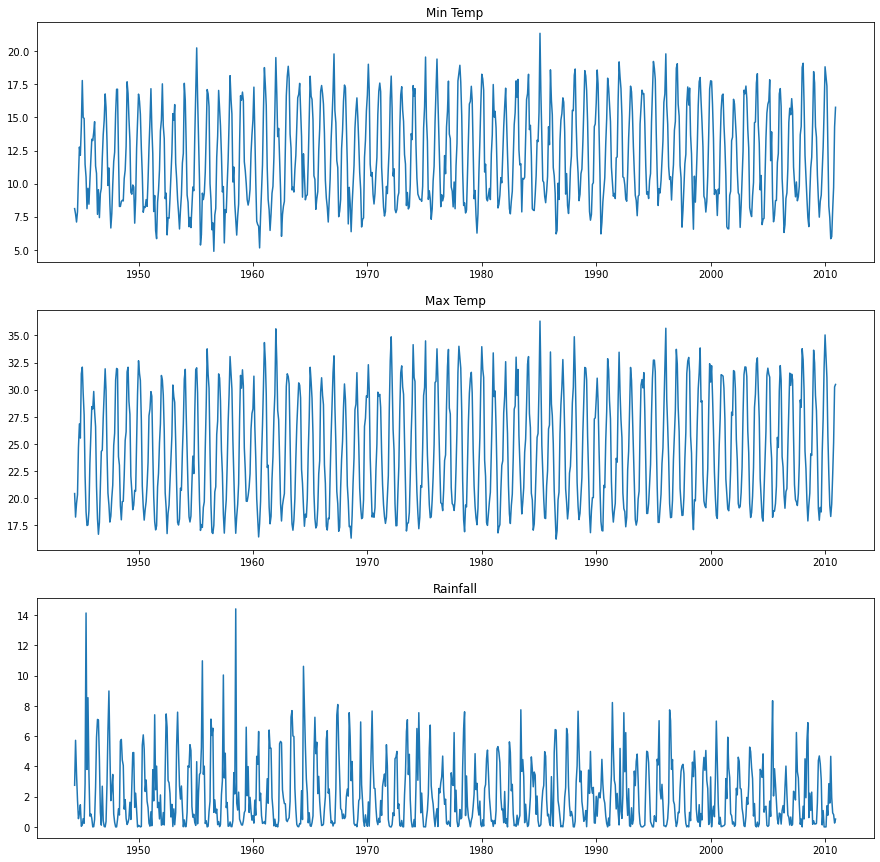

In [22]:
plt.figure(figsize=(15,15))

plt.subplot(3, 1, 1)
plt.title('Min Temp')
plt.plot(perthTempMS_Train['Minimum temperature (Degree C)'])

plt.subplot(3, 1, 2)
plt.title('Max Temp')
plt.plot(perthTempMS_Train['Maximum temperature (Degree C)'])

plt.subplot(3, 1, 3)
plt.title('Rainfall')
plt.plot(perthTempMS_Train['Rainfall amount (millimetres)'])


plt.show()

### Forecasting with Prophet

#### Renaming the columns to suit Prophet's requirements

In [24]:
perthTemp_Train.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp',
                                'Rainfall amount (millimetres)':'y'}, inplace = True)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [25]:
perthTemp_Train.reset_index(inplace = True)

In [26]:
perthTemp_Train.rename(columns={'Date':'ds'}, inplace = True)

In [27]:
perthTemp_Train

,ds,mintemp,maxtemp,y
0,1944-06-03,11.0,22.3,0.0
1,1944-06-04,12.2,23.4,0.0
2,1944-06-05,12.0,20.3,2.0
3,1944-06-06,7.4,18.7,3.3
4,1944-06-07,5.9,21.3,0.3
...,...,...,...,...
24313,2010-12-27,21.1,40.7,0.0
24314,2010-12-28,19.2,31.7,0.0
24315,2010-12-29,17.2,30.5,0.0
24316,2010-12-30,13.2,33.4,0.0


### Model

In [28]:
model = fbprophet.Prophet()

#### Adding regressors to the Prophet Model

In [29]:
model.add_regressor('mintemp', standardize=True)
model.add_regressor('maxtemp', standardize=True)

In [30]:
model.fit(perthTemp_Train)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [31]:
model.params

{'k': array([[-0.01661268]]),
 'm': array([[0.02017591]]),
 'delta': array([[-9.31650069e-07,  1.27438686e-02,  1.21563607e-02,
         -1.38294016e-06, -1.47681186e-02, -2.60623935e-02,
         -6.29424511e-05, -8.04582237e-03, -9.45225620e-08,
          2.40916369e-02,  2.55693013e-02,  6.23019304e-03,
          1.09289621e-07, -2.30646071e-02, -4.63492869e-04,
          2.35256860e-06,  6.40456049e-04,  1.44086826e-03,
          1.18020319e-04, -1.49516441e-06,  5.60342844e-07,
          3.33391588e-03,  2.16216730e-02,  7.11410511e-06,
         -2.80932943e-03]]),
 'sigma_obs': array([[0.0398714]]),
 'beta': array([[-1.51269591e-03, -1.16338161e-02,  3.99146302e-04,
          5.15276961e-03,  9.83225382e-04, -1.71584505e-03,
          8.43619804e-05,  2.21016258e-05,  5.01805998e-04,
          4.02511792e-04, -4.32811252e-04, -1.27470324e-03,
          5.84146076e-04,  5.56728300e-04, -7.89260579e-04,
          7.30814464e-05,  6.81697547e-04,  2.99562266e-04,
         -1.2177856

#### Forecast Dates

In [32]:
forecastDates = perthTemp_Test.drop(columns = ['Rainfall amount (millimetres)']).rename(columns = {'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp'}).reset_index().rename(columns = {'Date':'ds'})

#### Generating forecasts

In [33]:
forecast_rainfall = model.predict(forecastDates)

In [34]:
forecast_rainfall_1 = forecast_rainfall[['ds', 'yhat']]

In [35]:
rainfall_Values = pd.concat([perthTemp_Test[['Rainfall amount (millimetres)']],
           forecast_rainfall_1.set_index('ds')], axis = 1).rename(columns = {'Rainfall amount (millimetres)':'actual'})

### Plotting the forecasts and actual values

In [36]:
rainfall_Values[rainfall_Values['yhat'] < 0] = 0

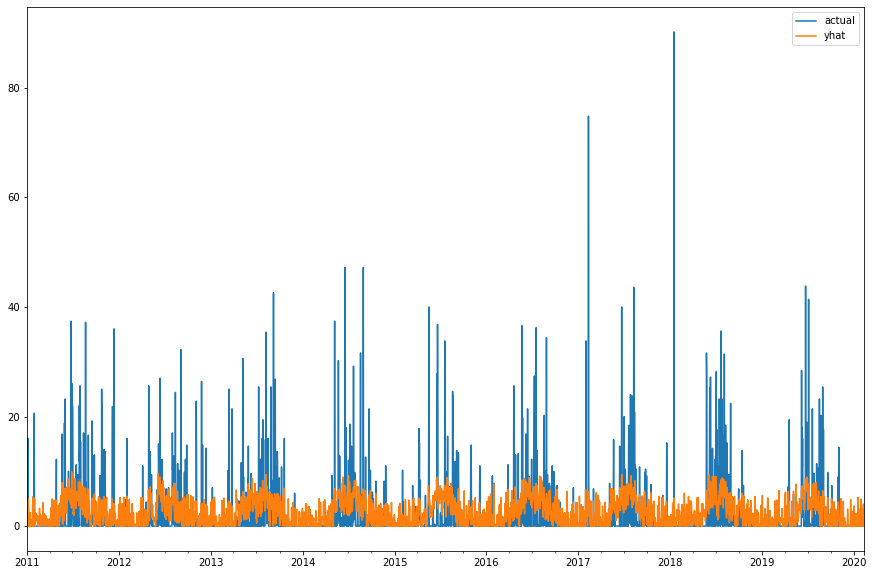

In [37]:
rainfall_Values.plot(figsize=(15,10))

plt.show()

### Evaluating the forecast performance

In [38]:
mae = mean_absolute_error(rainfall_Values['actual'], rainfall_Values['yhat'])
print('MAE: %.3f' % mae)

mape = mean_squared_error(rainfall_Values['actual'], rainfall_Values['yhat'], squared=False)
print('RMSE: %.3f' % mape)

MAE: 2.655
RMSE: 5.061


### Forecasting with monthly average data

In [39]:
perthTempMS_Train

,Minimum temperature (Degree C),Maximum temperature (Degree C),Rainfall amount (millimetres)
Date,,,
1944-06-01,8.107143,20.421429,2.750000
1944-07-01,7.700000,18.254839,5.722581
1944-08-01,7.093548,19.509677,3.493548
1944-09-01,7.870000,20.316667,1.770000
1944-10-01,10.487097,24.648387,0.545161
...,...,...,...
2010-08-01,5.980645,19.454839,1.935484
2010-09-01,8.016667,22.140000,0.926667
2010-10-01,9.703226,25.129032,0.812903


In [40]:
perthTempMS_Train.rename(columns={'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp',
                                'Rainfall amount (millimetres)':'y'}, inplace = True)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [41]:
perthTempMS_Train.reset_index(inplace = True)

In [44]:
perthTempMS_Train.rename(columns={'Date':'ds'}, inplace = True)

D:\Software\Anaconda3\envs\MachineLearning\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [45]:
perthTempMS_Train

,ds,mintemp,maxtemp,y
0,1944-06-01,8.107143,20.421429,2.750000
1,1944-07-01,7.700000,18.254839,5.722581
2,1944-08-01,7.093548,19.509677,3.493548
3,1944-09-01,7.870000,20.316667,1.770000
4,1944-10-01,10.487097,24.648387,0.545161
...,...,...,...,...
794,2010-08-01,5.980645,19.454839,1.935484
795,2010-09-01,8.016667,22.140000,0.926667
796,2010-10-01,9.703226,25.129032,0.812903
797,2010-11-01,14.290000,30.260000,0.253333


### Creating Prophet Model with additional regressors

In [47]:
model = None
model = fbprophet.Prophet()

In [48]:
model.add_regressor('mintemp', standardize=True)
model.add_regressor('maxtemp', standardize=True)

In [49]:
model.fit(perthTempMS_Train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


### Forecast Dates

In [50]:
forecastDates = perthTempMS_Test.drop(columns = ['Rainfall amount (millimetres)']).rename(columns = {'Minimum temperature (Degree C)':'mintemp',
                                'Maximum temperature (Degree C)':'maxtemp'}).reset_index().rename(columns = {'Date':'ds'})

### Generating Forecasts

In [51]:
forecast_rainfall = model.predict(forecastDates)

In [52]:
forecast_rainfall_1 = forecast_rainfall[['ds', 'yhat']]

In [53]:
rainfall_Values = pd.concat([perthTempMS_Test[['Rainfall amount (millimetres)']],
           forecast_rainfall_1.set_index('ds')], axis = 1).rename(columns = {'Rainfall amount (millimetres)':'actual'})

### Plot

In [54]:
rainfall_Values[rainfall_Values['yhat'] < 0] = 0

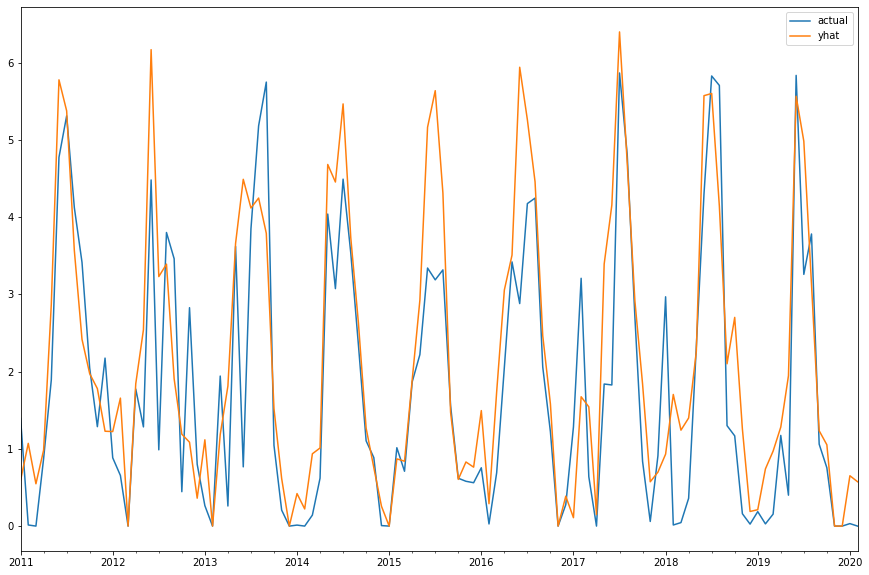

In [55]:
rainfall_Values.plot(figsize=(15,10))

plt.show()

### Evaluate

In [56]:
mae = mean_absolute_error(rainfall_Values['actual'], rainfall_Values['yhat'])
print('MAE: %.3f' % mae)

mape = mean_squared_error(rainfall_Values['actual'], rainfall_Values['yhat'], squared=False)
print('RMSE: %.3f' % mape)

MAE: 0.741
RMSE: 1.022
